# PCA:
Constructing a supervised learning pipeline that integreates PCA and kNN to perform facial recognition.

In [1]:
#import needed packages
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Dataset
from sklearn.datasets import fetch_olivetti_faces

In [2]:
#Helper functions taken from lab 8
def extract_loadings(pca, feature_names=None, pipeline_component=None, prefix='PC'):
    if pipeline_component is not None:
        pca = pca[pipeline_component]
        
    X = pca.components_.T
    
    return pd.DataFrame(X, columns=[ f'{prefix}{i+1}' for i in range(X.shape[1]) ], index=feature_names)

def screeplot(pca, pipeline_component=None, prefix='PC', n_components=None):
    import seaborn as sns
    from matplotlib import pyplot as plt
    
    if pipeline_component is not None:
        pca = pca[pipeline_component]

    explained_variance = pca.explained_variance_ratio_
    if n_components is not None: explained_variance = explained_variance[0:n_components]
    
    total_variance = np.cumsum(explained_variance)
    ticks = range(len(explained_variance))
    labels = [ f'{prefix}{i+1}' for i in ticks ]

    plt.bar(x=range(len(explained_variance)), height=explained_variance, label='Component')
    plt.plot(range(len(total_variance)), total_variance, 'o-', color='#ce2227', linewidth=2, label='Cumulative')
    plt.xticks(ticks=ticks, labels=labels)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance')
    plt.legend()

Shape of the image array is (400, 4096), suggesting that each image has 4096 pixels


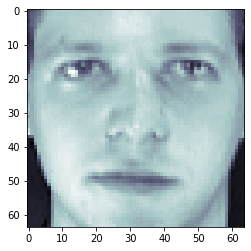

In [3]:
#Load image data and inspect properties
faces = fetch_olivetti_faces();

#Set data
X, t = faces['data'], faces['target']
image_pixels = X.shape[1]
image_dim = np.sqrt(image_pixels).astype(int)#needed for visualisation later

#print image size taken from lab 8
print(f'Shape of the image array is {X.shape}, suggesting that each image has {X.shape[1]} pixels')

#Visualise first image
original_image = X[0, :].reshape(1, -1)
fig = plt.figure(figsize=(4, 4))
plt.imshow(original_image.reshape(image_dim, image_dim), cmap='bone')
plt.show()

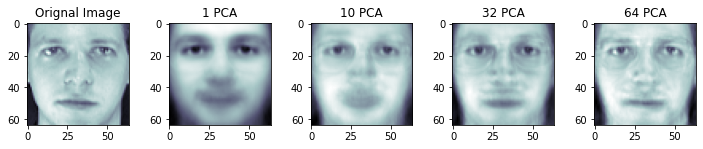

In [4]:
#Visualise first few principal components to gather insights

#Create PCA transformers with different number of components
pca1  = PCA(n_components=1).fit(X)
pca10 = PCA(n_components=10).fit(X)
pca32 = PCA(n_components=32).fit(X)
pca64 = PCA(n_components=64).fit(X)

#transform original image for each pca transformer
reduced_image_1  = pca1.transform(original_image)
reduced_image_10  = pca10.transform(original_image)
reduced_image_32  = pca32.transform(original_image)
reduced_image_64  = pca64.transform(original_image)

#recreate image with reduced image
recreated_image_1 = pca1.inverse_transform(reduced_image_1)
recreated_image_10 = pca10.inverse_transform(reduced_image_10)
recreated_image_32 = pca32.inverse_transform(reduced_image_32)
recreated_image_64 = pca64.inverse_transform(reduced_image_64)

#Visualise original image to recreated images, shamelessly taken from tutorial 7
original_image = original_image.reshape(image_dim, image_dim)
recreated_image_1 = recreated_image_1.reshape(image_dim, image_dim)
recreated_image_10 = recreated_image_10.reshape(image_dim, image_dim)
recreated_image_32 = recreated_image_32.reshape(image_dim, image_dim)
recreated_image_64 = recreated_image_64.reshape(image_dim, image_dim)

fig = plt.figure(figsize=(10, 2))

fig.add_subplot(1, 5, 1)
plt.imshow(original_image, cmap='bone')
plt.title(f'Orignal Image')
fig.add_subplot(1, 5, 2)
plt.imshow(recreated_image_1, cmap='bone')
plt.title(f'{pca1.n_components} PCA')
fig.add_subplot(1, 5, 3)
plt.imshow(recreated_image_10, cmap='bone')
plt.title(f'{pca10.n_components} PCA')
fig.add_subplot(1, 5, 4)
plt.imshow(recreated_image_32, cmap='bone')
plt.title(f'{pca32.n_components} PCA')
fig.add_subplot(1, 5, 5)
plt.imshow(recreated_image_64, cmap='bone')
plt.title(f'{pca64.n_components} PCA')

plt.tight_layout()
plt.show()

From the plot of the recreated images, we can see that the principal components represent a feature of the face being identified. This can be seen in the image of recreated_image_1, where the eyes of the face is really distinct compared to the other facial features. 

As the number of principal components increase, we can see that more features are being identified and the image is generally blurry as its identifying more features. This means that the important facial features have already been identified with the earlier principal components as seen in 1 PCA plot.
This means that the low-order principal components represent basic features in a face such as the eyes and mouth and the high order principal components represent minor feature that contributes to more feature detection thus improving the facial recognition ability.

In [5]:
#Pipeline and cross validation


#import further things
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, RepeatedKFold

#set number of principal components for 10 fold CV
pc = np.unique(np.logspace(np.log10(1), np.log10(360), 20, base=10).astype(int))
#set number of folds
folds = RepeatedKFold(n_splits=10, n_repeats= 3, random_state=1234)

#Create pipeline
pipe = Pipeline([('Scaler', StandardScaler()),
                 ('PCA', PCA()),
                 ('kNN', KNeighborsRegressor())
                ])

#param grid
param_grid = {
    'PCA__n_components' : pc,
    'kNN__n_neighbors' : [1]
}

#Grid Search

cv = GridSearchCV(pipe, param_grid=param_grid, cv=folds, n_jobs= -1).fit(X, t)

#Get best number of components
pca = cv.best_estimator_['PCA']

print(f"best score: {cv.best_score_} and best params: {cv.best_params_}\n")

print(pca)


best score: 0.8336836711384873 and best params: {'PCA__n_components': 360, 'kNN__n_neighbors': 1}

PCA(n_components=360)


According to the cross validation, the ideal number of principal components would be 360 in a cross validation of 1 - nearest neighbour learning, which is the largest number in the array of logspace values between 1 and 360.

Now we can construct 4 PCA objects and compare them by transforming then reverse transforming them. Then we shall take 5 images from the data set and visualise the images in their orignal form and reduced form for each of the 4 PCA instances.

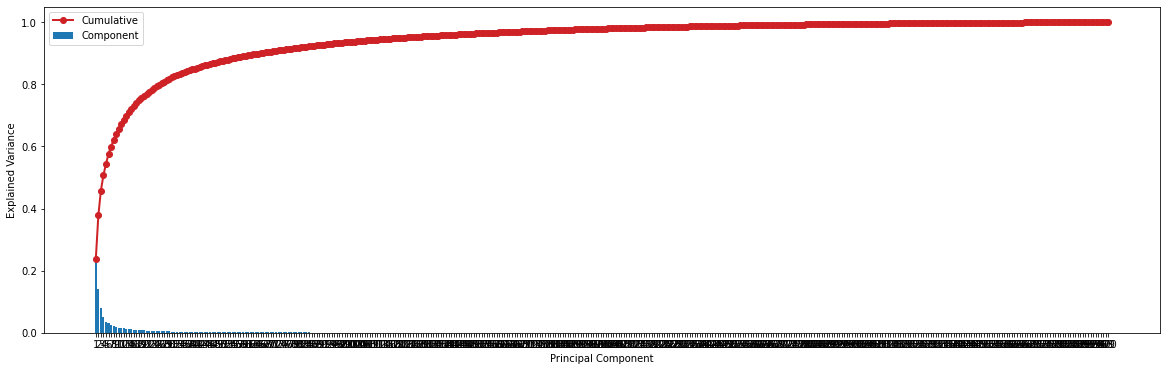

In [6]:
#Find PCA that explains 80% of variance.
fig = plt.figure(figsize=(20,6))

#PCA with default components
pcaD = PCA().fit(X)

#Screeplot of ALL the components
screeplot(pcaD, prefix = '')
plt.show()

Screeplot above is not very helpful. Using a loop instead

In [7]:
explained = 0
for x in range(500):
    n = np.cumsum(pcaD.explained_variance_ratio_)[x]
    if(n >= 0.8):
        explained = x
        break
print(f"no. components that explains 80% variance: {explained}")


no. components that explains 80% variance: 26


From the loop above, the first few 26 principal components explain 80% of the variance in the data.
Constructing 4 PCA objects and looping to visualise images to compare

Image 1


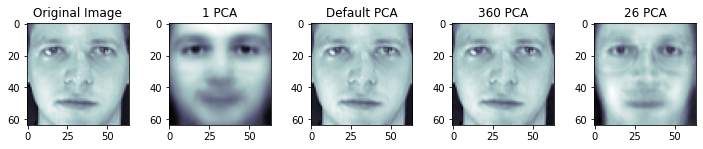

Image 2


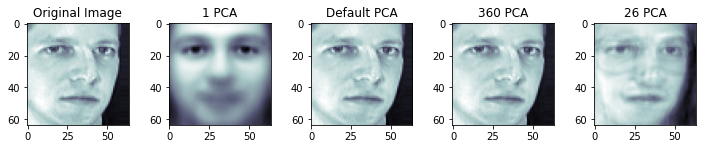

Image 3


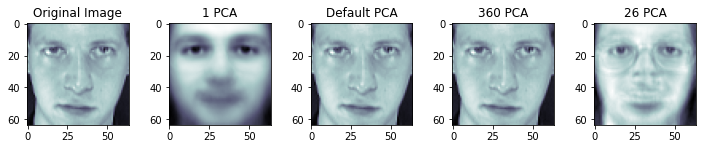

Image 4


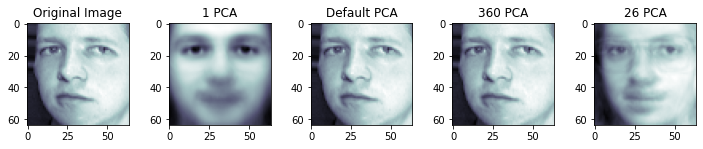

Image 5


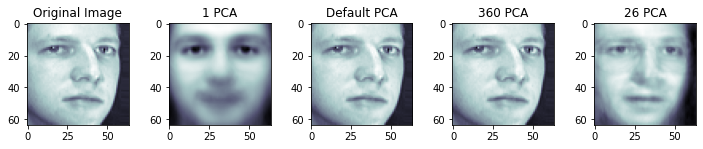

In [8]:
#First PCA with 1 feature
pca1  = PCA(n_components=1).fit(X)

#PCA with default components
pcaD = PCA().fit(X)

#PCA with best components found in cross validation
pcaCV = PCA(n_components=360).fit(X)

#PCA with 80% variance explained
pca80 = PCA(n_components=26).fit(X)

#Loop to produce original and reduced form by the 4 PCA instances
for n in range(5):
    print(f"Image {n + 1}")
    #image sample from dataset
    image = X[n, :].reshape(1,-1)
    image.reshape(image_dim, image_dim)

    #transform image
    reduced_image_1  = pca1.transform(image)
    reduced_image_D  = pcaD.transform(image)
    reduced_image_CV  = pcaCV.transform(image)
    reduced_image_80  = pca80.transform(image)

    #reverse transform image
    recreated_image_1  = pca1.inverse_transform(reduced_image_1)
    recreated_image_D  = pcaD.inverse_transform(reduced_image_D)
    recreated_image_CV  = pcaCV.inverse_transform(reduced_image_CV)
    recreated_image_80  = pca80.inverse_transform(reduced_image_80)

    #reshape
    image = image.reshape(image_dim, image_dim)
    recreated_image_1 = recreated_image_1.reshape(image_dim, image_dim)
    recreated_image_D = recreated_image_D.reshape(image_dim, image_dim)
    recreated_image_CV = recreated_image_CV.reshape(image_dim, image_dim)
    recreated_image_80 = recreated_image_80.reshape(image_dim, image_dim)

    #plot
    fig = plt.figure(figsize=(10, 2))

    fig.add_subplot(1, 5, 1)
    plt.imshow(image, cmap='bone')
    plt.title(f'Original Image')
    fig.add_subplot(1, 5, 2)
    plt.imshow(recreated_image_1, cmap='bone')
    plt.title(f'{pca1.n_components} PCA')
    fig.add_subplot(1, 5, 3)
    plt.imshow(recreated_image_D, cmap='bone')
    plt.title(f'Default PCA')
    fig.add_subplot(1, 5, 4)
    plt.imshow(recreated_image_CV, cmap='bone')
    plt.title(f'{pcaCV.n_components} PCA')
    fig.add_subplot(1, 5, 5)
    plt.imshow(recreated_image_80, cmap='bone')
    plt.title(f'{pca80.n_components} PCA')

    plt.tight_layout()
    plt.show()



From the plots of the 5 images above, we can see that the role of PCA in Eigenfaces is a feature extractor and each feature is a distinct facial feature.
We can see that from having 1 PCA, it identifies one distinct facial feature, in this case the eyes. For all 5 images, the 1 PCA image is the same as it was meant to check if the eyes exist and its position. 

By having 26 components which explains 80% of the variance, we can see that it picks up all the distinct facial features (eyes, nose, mouth etc) along with additonal features such as glasses or wrinkles. For example, in image 2, the outline of the image having a possibility of including glasses can be seen along with the faint wrinkles of the face.

For the default number of components and the ideal number of components identified by cross validation, we can see that it practically identical to the original image. Relating back to how PCA is a feature extractor, the more components the PCA has, the more features it is able to extract.
Although having 26 components explains 80% of the variance in data, having additonal components would allow tiny facial features to be extracted, making it able to produce images identical to the original image which the default PCA and the PCA with best number of components identified by cross validation has done.

# Ensemble Learning:



Examine bagging and boosting on the data set in Lab 9 and on the water quality data set

Total prediction is the combination of bias and variance.
Bias is the flexibility of the learning method and variance is the response to noise in sampling and during learning. Models should trade bias and variance to obtain the lowest overall error. If not, overfitting and underfitting would happen.

Ensemble learning forms a team of base learner models into an group and combines the prediction of these models in a process called aggregation.
Base learners can either learn independantly or learn by building from the results of the previous learner. A characteristic required for ensemble to work is diversity in each model's predictions. This can be achieved through specialisation, where the model focuses on a unique component of the problem or decorrelation, where errors made by the learner models are not correlated. 

Bagging and boosting are methods that use of ensemble learning to reduce error.
Bagging builds several models from a low bias learner, each learned from a bootstrap sample of the original data, then averaging the predictions to lower the overall variance and total error.
Boosting builds several models from a high bias learner, each model built on the residuals of the previous model. The sum of the predicions from these models would be for the final prediction, which lowers the bias and the total error.

In [9]:
#import more packages

from sklearn.datasets import make_friedman1, load_digits
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

Examining bagging and boosting on the lab 9 dataset by doing bias-variance decompositions.
In lab 9, we used mean squared error to determine the performance of each split. Therefore, for this task we shall also use mean squared error

After each bias-variance decomposition of each learning method. We would examine the performance of bagging and boosting on the water quality data set

In [10]:
#Datasets from lab 9

X_test, t_test = make_friedman1(n_samples=1000, random_state=1234)

#smaller training samples
M = [ make_friedman1(n_samples=100, random_state=rng_state) for rng_state in range(50) ]

In [11]:
#Sort dataset making pH the target variable
from sklearn.model_selection import train_test_split

data = pd.read_csv("water_quality.csv")
target = 'pH'
feature = data.drop(columns=[target]).columns.values #feature would be the column values for tree plot later
X = data.drop(columns=[target]).to_numpy()
t = data[target].to_numpy()

#split to 70% train, 30% test
X_train2, X_test2, t_train2, t_test2 = train_test_split(X, t, test_size=0.3)

 ### Decision Tree Regressor:

Best minsplit value: 16


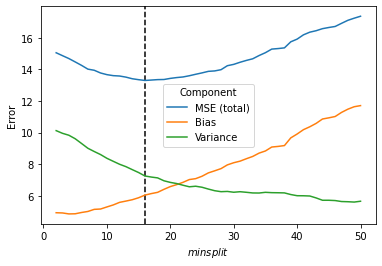

In [12]:
#Decision Tree Regressor bias-variance decomposition
min_splits = np.arange(2,51)

results = []

for m, (X_train, t_train) in enumerate(M):
    for minsplit in min_splits:
        mdl = DecisionTreeRegressor(random_state=0, min_samples_split=minsplit).fit(X_train, t_train)
        y_test = mdl.predict(X_test)
        for i, y in enumerate(y_test):
            results.append({ 'minsplit' : minsplit, 'i': i, 'y' : y })
results = pd.DataFrame(results)

#Decomposition from lab 9
ybar = results.groupby([ 'minsplit', 'i' ]).agg(ybar=('y', 'mean')).reset_index()
t = pd.DataFrame({ 'i' : range(len(t_test)), 't' : t_test })

decomp = results.merge(ybar, on=[ 'minsplit', 'i' ]).merge(t, on='i')

decomp['mse'] = (decomp['t'] - decomp['y'])**2  
decomp['bias'] = (decomp['t'] - decomp['ybar'])**2  
decomp['var'] = (decomp['y'] - decomp['ybar'])**2   

decomp = decomp.groupby('minsplit').agg({ 'mse' : np.mean, 'bias' : np.mean, 'var' : np.mean }).reset_index()
best_minsplit = decomp[decomp['mse']==decomp['mse'].min()]['minsplit'].values[0]
print(f'Best minsplit value: {best_minsplit}')

sns.lineplot(data=decomp.melt(id_vars='minsplit'), x='minsplit', y='value', hue='variable').set(xlabel='$minsplit$', ylabel='Error')
plt.axvline(x=best_minsplit, c='black', linestyle='--', zorder=1)
plt.legend(title='Component', labels=['MSE (total)', 'Bias', 'Variance'])
plt.show()


From the plot above, we can see that between minsplit values is 16. Before the best minsplit value, MSE and Variance were decreasing in error while Bias is slowly increasing. However, after the minsplit value, Bias kept increasing at a faster rate and MSE started to increase slowly as the minsplit value gets larger. However, Variance continues to decrease.
Minsplit value 16 has the best tradeoff for lowest overall error.

In [13]:
#GridSearch and cross validation to identify the best DecisionTreeRegressor model for the
#water quality dataset

samples = [2,4,8,16,32,64,128,256,512,1024]

pipe = Pipeline([('dtt', DecisionTreeRegressor())])

param_grid = {
    'dtt__min_samples_split' : samples
}

scorer = make_scorer(r2_score)

cv = GridSearchCV(pipe, param_grid=param_grid, scoring= scorer, n_jobs=-1).fit(X_train2, t_train2)

bestscoreDT = cv.best_score_
bestparamsDT = cv.best_params_

print(f"Best params is {bestparamsDT} and best score is {bestscoreDT}")

Best params is {'dtt__min_samples_split': 32} and best score is 0.7416330833544518


From the grid search, we can see that the best number of splits for a decision tree regressor is 64 and with a poor r squared score of 0.742

### Random Forest Regressor: 

Best estimators value: 50


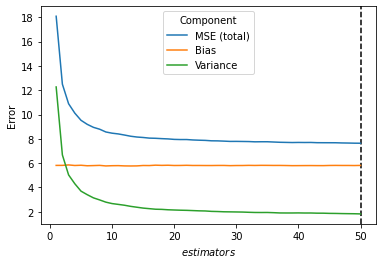

In [14]:
#Random Forest Regressor bias-variance decomposition

n_estimators = np.arange(1,51)

results2 = []

for i, (X_train, t_train) in enumerate(M):
    for est in n_estimators:
        mdl = RandomForestRegressor(n_estimators=est, random_state=0, n_jobs=-1).fit(X_train, t_train)
        y_test = mdl.predict(X_test)
        for i, y in enumerate(y_test):
            results2.append({ 'n_estimators' : est, 'i': i, 'y' : y })

results2 = pd.DataFrame(results2)

#Decomposition from lab 9
ybar = results2.groupby([ 'n_estimators', 'i' ]).agg(ybar=('y', 'mean')).reset_index()
t = pd.DataFrame({ 'i' : range(len(t_test)), 't' : t_test })

decomp = results2.merge(ybar, on=[ 'n_estimators', 'i' ]).merge(t, on='i')

decomp['mse'] = (decomp['t'] - decomp['y'])**2   
decomp['bias'] = (decomp['t'] - decomp['ybar'])**2  
decomp['var'] = (decomp['y'] - decomp['ybar'])**2   

decomp = decomp.groupby('n_estimators').agg({ 'mse' : np.mean, 'bias' : np.mean, 'var' : np.mean }).reset_index()

best_minsplit = decomp[decomp['mse']==decomp['mse'].min()]['n_estimators'].values[0] 
print(f'Best estimators value: {best_minsplit}')

sns.lineplot(data=decomp.melt(id_vars='n_estimators'), x='n_estimators', y='value', hue='variable').set(xlabel='$estimators$', ylabel='Error')
plt.axvline(x=best_minsplit, c='black', linestyle='--', zorder=1)
plt.legend(title='Component', labels=['MSE (total)', 'Bias', 'Variance'])
plt.show()

From the plot above, we can see that a low bias learner is selected and the variance and MSE decreases sharply as the number of estimators increase. Although the best estimators value is 50, we can see that the sharpest decrease in error occurs around 4 or 5 number of estimators and afterwards, the decrease in error is very minimal.

Bias error value remains the same throughout the number of estimators which is the effect of bagging where variance is decreased in a low bias learner.

In [15]:
#Fit a RandomForestRegressor on water quality dataset
mdl = RandomForestRegressor(n_estimators=50, n_jobs=-1).fit(X_train2, t_train2)
y_test = mdl.predict(X_test2)
scoreRF = r2_score(t_test2, y_test)
print(f"Score of RFR: {scoreRF}")

Score of RFR: 0.8463208494070472


From the score of 0.846 for the RandomForestRegressor, it has a better score than the DecisionTreeRegressor.

*Scores between RandomForest and GradientBoosting might change

There is no need to use cross validation to tune the model. Cross validation is used for model checking to identify the best model among a sample of models. For Random Forest Regressor, each model is learned from a bootstrap sample of the original data, it then averages the predictons. Cross validation does not help here as the ensemble requires all its models to have 

### Gradient Boosting Regressor:

Best estimators value: 50


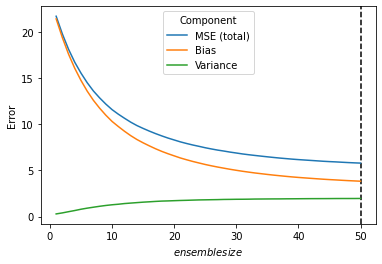

In [16]:
#Gradient Boosting Regressor bias-variance decomposition

n_tree = np.arange(1, 51)

results3 = []

for i, (X_train, t_train) in enumerate(M):
    for n in n_tree:
        mdl = GradientBoostingRegressor(n_estimators=n, random_state=0).fit(X_train, t_train)
        y_test = mdl.predict(X_test)
        for i, y in enumerate(y_test):
            results3.append({ 'ensemble_size' : n, 'i': i, 'y' : y })

results3 = pd.DataFrame(results3)

#Decomposition from lab 9
ybar = results3.groupby([ 'ensemble_size', 'i' ]).agg(ybar=('y', 'mean')).reset_index()
t = pd.DataFrame({ 'i' : range(len(t_test)), 't' : t_test })

decomp = results3.merge(ybar, on=[ 'ensemble_size', 'i' ]).merge(t, on='i')

decomp['mse'] = (decomp['t'] - decomp['y'])**2   
decomp['bias'] = (decomp['t'] - decomp['ybar'])**2  
decomp['var'] = (decomp['y'] - decomp['ybar'])**2   

decomp = decomp.groupby('ensemble_size').agg({ 'mse' : np.mean, 'bias' : np.mean, 'var' : np.mean }).reset_index()

best_minsplit = decomp[decomp['mse']==decomp['mse'].min()]['ensemble_size'].values[0] 
print(f'Best estimators value: {best_minsplit}')

sns.lineplot(data=decomp.melt(id_vars='ensemble_size'), x='ensemble_size', y='value', hue='variable').set(xlabel='$ensemble size$', ylabel='Error')
plt.axvline(x=best_minsplit, c='black', linestyle='--', zorder=1)
plt.legend(title='Component', labels=['MSE (total)', 'Bias', 'Variance'])
plt.show()

From the plot above, MSE and bias decrease as the ensemble size increases. The variance slightly increases but is still substantially low. Similar to the RandomForest decomposition, the best ensemble size is 50 as it has the lowest error but ensemble size 11-13 has the biggest decrease in error.

Although the variance increases slightly, it remains relatively low which is the effect of boosting as the bias is lowered in a low variance learner.

In [17]:
#Cross validation to identify the best GradientBoostingRegressor
depth = range(1,11)

rate = [0.1,0.3,1.0]

pipe = Pipeline([('GBR', GradientBoostingRegressor())])

param_grid = {
    'GBR__n_estimators' : [50],
    'GBR__max_depth' : depth,
    'GBR__learning_rate' : rate
}

scorer = make_scorer(r2_score)

cv = GridSearchCV(pipe, param_grid=param_grid, scoring= scorer, n_jobs=-1).fit(X_train2, t_train2)

bestscoreGB = cv.best_score_
bestparamsGB = cv.best_params_

print(f"Best params is {bestparamsGB} and best score is {bestscoreGB}")

Best params is {'GBR__learning_rate': 0.1, 'GBR__max_depth': 7, 'GBR__n_estimators': 50} and best score is 0.837589521447655


From the cross validation, we can see that the best parameters for the optimal score of 0.838 is 0.1 for the learning rate, depth of 7 with 50 estimators. It has a better score than DecisionTree but its score is only slightly worst compared to RandomForest

*Scores between RandomForest and GradientBoosting might change

### Discussion of R squared performance

In [18]:
#printing scores of DTT, RFR and GBR
print(f"Score of DTR {bestscoreDT}")
print(f"Score of RFR: {scoreRF}")
print(f"Score of GBR: {bestscoreGB}")

Score of DTR 0.7416330833544518
Score of RFR: 0.8463208494070472
Score of GBR: 0.837589521447655


From the scores above, we can see that the performance of the decision tree is worse than the ensemble methods. Comparing the two ensemble methods, it appears that RandomForest has a slightly better performance. However, the two ensemble methods are used differently as RandomForest aims to lower the variance in a low bias learner while GradientBoosting aims to lower the bias in a low variance learner.

Relating back to the graphs of the bias-variance decompositons, we can see that the mean squared error is slighly lower for GradientBoosting compared to RandomForest which might explain the slight differences in scores.

The ensemble methods improve the performance on this problem as they either reduce the bias or variance depending if the learner is a low bias or high variance. This balances the trade off between bias and variance which results in no overfitting or underfitting, making the overall error lower thus improving the performance on this problem.

Insights can be easily extracted from ensemble methods compared to a single decision tree is due to the layers of the trees. In a single tree, the important variables would be the top few branches of the tree. However, if multiple trees are present, insight is hard to obtain as not all trees are the same and would differ as each tree is different from one another